[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/02-ollama-langgraph-agent/02-ollama-langgraph-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/02-ollama-langgraph-agent/02-ollama-langgraph-agent.ipynb)

# Ollama LangGraph Agent

LangGraph is one of the most powerful frameworks for build AI agents, and Ollama one of the most popular frameworks for running local LLMs. Bringing both together allows us to run agentic workflows at little-to-no cost. In this example we will see how.

We recommend running this locally (ideally on Apple silicon). For environment setup instructions you can refer to the README found in this directory.

If using Colab, you should run the following installs (no need to run if installing locally with `poetry`):

```
!pip install -qU \
    langchain==0.2.12 \
    langchain-core==0.2.29 \
    langgraph==0.2.3 \
    langchain-ollama==0.1.1 \
    semantic-router==0.0.61 \
    pyppeteer==2.0.0 \
    nest-asyncio==1.6.0 \
    praw==7.7.1
```

## Reddit Search Tool

We first need to sign up for the Reddit API, you can refer to the first few minutes of [this tutorial](https://www.youtube.com/watch?v=FdjVoOf9HN4) if you want a full walkthrough, but tldr;

1. Go to [App Preferences](https://www.reddit.com/prefs/apps) and click **_create another app..._** at the bottom.
2. Fill out required details, make sure to select *script* for the application type then click **_create app_**.
3. Fill out the next cell with `client_id` (your *personal use script*) and `client_secret` (your *secret* key).

In [1]:
import praw

reddit = praw.Reddit(
    client_id="---",  # personal use script
    client_secret="---",  # secret
    user_agent="search-tool"  # name of application
)

We'll be pulling in submission threads from Reddit that include user's restaurant recommendations (or just other info we search for). From the submission threads we need:

* Submission title
* Submission first text / description
* A few of the top voted comments

To organize this information we can create a pydantic class to structure the needed data:

In [2]:
from pydantic import BaseModel

class Rec(BaseModel):
    title: str
    description: str
    comments: list[str]

    def __str__(self):
        """LLM-friendly string representation of the recommendation(s)."""
        return f"Title: {self.title}\nDescription: {self.description}\nComments:\n{'\n'.join(self.comments)}"

Now we setup the retrieval logic for an example query `"best pizza in rome"`:

In [3]:
from praw.models import Comment

# search across all subreddits for pizza recommendations
results = reddit.subreddit("all").search("best pizza in rome")
recs = []
for submission in results:
    title = submission.title
    description = submission.selftext
    # we only get comments with 20 or more upvotes
    comments = []
    for comment in submission.comments.list():
        if isinstance(comment, Comment) and comment.ups >= 20:
            author = comment.author.name if comment.author else "unknown"
            comments.append(f"{author} (upvotes: {comment.ups}): {comment.body}")
    # and of these, we only need 3
    comments = comments[:3]
    # if there are enough comments (ie 3), we add the recommendation to our list
    if len(comments) == 3:
        print(title)
        recs.append(Rec(title=title, description=description, comments=comments))
    if len(recs) == 3:
        # stop after getting 3 recommendations
        break

Best pizza in Rome?
Visited Rome and had one of the best pizzas of my life
Since pizza is an American food, I'm willing to bet the best pizza is in America.


Let's see what we have:

In [4]:
print("\n===\n".join([str(rec) for rec in recs]))

Title: Best pizza in Rome?
Description: I was a little disappointed after my first experience tasting pizza after pasta and gelato were ridiculously amazing. What do you recommend? 
Comments:
miclee15 (upvotes: 23): American here.  I think if OP is from the USA, Rome pizza needs to be approached differently.  I’m from NY where we think that is the best pizza in the US, people from Chicago will disagree.  Set aside the preconceived notion of what great pizza should be and enjoy the variety and flavors.   I’m in Rome now.  Went to Antico Forno Roscioli and had the most amazing porcetta pizza with potatoes on top.  I still love a NYC slice but Rome pizza is incredible at some places.  Edited for spelling
Sisyphus_Rock530 (upvotes: 29): 

- **Pizzeria da Remo** a Testaccio, nota per la sua base sottile e croccante, è molto popolare tra i romani. https://www.romeing.it/best-pizza-in-rome/).


- **Emma** vicino Campo de' Fiori, famosa per la sua pizza a crosta sottile e ingredienti di alta q

Let's put all of this together into a single `tool` that our LLM will be connected to for function calling.

In [5]:
def search(query: str) -> list[Rec]:
    """Provides access to search reddit. You can use this tool to find restaurants.
    Best results can be found by providing as much context as possible, including
    location, cuisine, and the fact that you're looking for a restaurant, cafe,
    etc.
    """
    # search across all subreddits for pizza recommendations
    results = reddit.subreddit("all").search(query)
    recs = []
    for submission in results:
        title = submission.title
        description = submission.selftext
        # we only get comments with 20 or more upvotes
        comments = []
        for comment in submission.comments.list():
            if isinstance(comment, Comment) and comment.ups >= 10:
                author = comment.author.name if comment.author else "unknown"
                comments.append(f"{author} (upvotes: {comment.ups}): {comment.body}")
        # and of these, we only want the top 3
        comments = comments[:3]
        # if there are enough comments (ie 3), we add the recommendation to our list
        if len(comments) == 3:
            print(title)
            recs.append(Rec(title=title, description=description, comments=comments))
        if len(recs) == 3:
            # stop after getting 3 recommendations
            break
    return recs

# we invoke the tool like so:
out = search(query="best pizza in rome")
out[:300]

Best pizza in Rome?
Visited Rome and had one of the best pizzas of my life
Best Pizza in Rome!


[Rec(title='Best pizza in Rome?', description='I was a little disappointed after my first experience tasting pizza after pasta and gelato were ridiculously amazing. What do you recommend? ', comments=['miclee15 (upvotes: 24): American here.  I think if OP is from the USA, Rome pizza needs to be approached differently.  I’m from NY where we think that is the best pizza in the US, people from Chicago will disagree.  Set aside the preconceived notion of what great pizza should be and enjoy the variety and flavors.   I’m in Rome now.  Went to Antico Forno Roscioli and had the most amazing porcetta pizza with potatoes on top.  I still love a NYC slice but Rome pizza is incredible at some places.  Edited for spelling', "Sisyphus_Rock530 (upvotes: 28): \n\n- **Pizzeria da Remo** a Testaccio, nota per la sua base sottile e croccante, è molto popolare tra i romani. https://www.romeing.it/best-pizza-in-rome/).\n\n\n- **Emma** vicino Campo de' Fiori, famosa per la sua pizza a crosta sottile e ing

### Final Answer "Tool"

Alongside our web search tool we will have a final tool called `final_answer`. The final answer tool will be called whenever the LLM has finished pulling info from the other two tools and is ready to provide a *final answer* to the user.

In [6]:
def final_answer(answer: str, phone_number: str = "", address: str = ""):
    """Returns a natural language response to the user. There are four sections 
    to be returned to the user, those are:
    - `answer`: the final natural language answer to the user's question, should provide as much context as possible.
    - `phone_number`: the phone number of top recommended restaurant (if found).
    - `address`: the address of the top recommended restaurant (if found).
    """
    return {
        "answer": answer,
        "phone_number": phone_number,
        "address": address,
    }

## Graph Construction

We are using LangGraph to create an agentic graph-based flow. To construct the graph we will use:

* **Agent State**: An object persisted through every step in the graph, used to provide input to nodes, and to store output from nodes to be used in later nodes or in our final output.
* **Local LLM**: We are using a local LLM (`llama-3.1:8b`) via Ollama. For tool use we turn on _JSON mode_ to reliably output parsible JSON.
* **Tools**: The tools our LLM can use, these allow use of the functions `search` and `final_answer`.
* **Graph Nodes**: We wrap our logic into components that allow it to be used by LangGraph, these consume and output the *Agent State*.


### Agent State

In [7]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    output: dict[str, Union[str, List[str]]]

### LLM and Tools

The LLM acts as our decision maker and generator of our final output, we will later call this component the `oracle` as our *decision-maker*. For this we are using Ollama and `Llama 3.1`, once initialized we integrate it into a runnable pipeline of our Oracle. The system prompt for our `oracle` will be:

In [11]:
system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

Your goal is to provide the user with the best possible restaurant
recommendation. Including key information about why they should consider
visiting or ordering from the restaurant, and how they can do so, ie by
providing restaurant address, phone number, website, etc.

Note, when using a tool, you provide the tool name and the arguments to use
in JSON format. For each call, you MUST ONLY use one tool AND the response
format must ALWAYS be in the pattern:

```json
{
    "name": "<tool_name>",
    "parameters": {"<tool_input_key>": <tool_input_value>}
}
```

Remember, NEVER use the search tool more than 3x as that can trigger
the nuclear annihilation system.

After using the search tool you must summarize your findings with the
final_answer tool. Note, if the user asks a question or says something
unrelated to restaurants, you must use the final_answer tool directly."""

Alongside our system prompt, we must also pass Ollama the schema of our functions for tool calls. [Tool calling](https://ollama.com/blog/tool-support) is a relatively new feature in Ollama and is used by providing function schemas to the `tools` parameter when calling our LLM.

We use `FunctionSchema` object with `to_ollama` from `semantic-router` to transform our functions into correctly formatted schemas.

In [8]:
from semantic_router.utils.function_call import FunctionSchema

# create the function calling schema for ollama
search_schema = FunctionSchema(search).to_ollama()
# TODO deafult None value for description and fix required fields in SR
search_schema["function"]["parameters"]["properties"]["query"]["description"] = None
search_schema

/Users/jamesbriggs/opt/anaconda3/envs/ollama-langgraph/lib/python3.12/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
/Users/jamesbriggs/opt/anaconda3/envs/ollama-langgraph/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'type': 'function',
 'function': {'name': 'search',
  'description': "Provides access to search reddit. You can use this tool to find restaurants.\nBest results can be found by providing as much context as possible, including\nlocation, cuisine, and the fact that you're looking for a restaurant, cafe,\netc.",
  'parameters': {'type': 'object',
   'properties': {'query': {'description': None, 'type': 'string'}},
   'required': []}}}

In [9]:
final_answer_schema = FunctionSchema(final_answer).to_ollama()
# TODO add to SR
for key in final_answer_schema["function"]["parameters"]["properties"].keys():
    final_answer_schema["function"]["parameters"]["properties"][key]["description"] = None
final_answer_schema

{'type': 'function',
 'function': {'name': 'final_answer',
  'description': "Returns a natural language response to the user. There are four sections \nto be returned to the user, those are:\n- `answer`: the final natural language answer to the user's question, should provide as much context as possible.\n- `phone_number`: the phone number of top recommended restaurant (if found).\n- `address`: the address of the top recommended restaurant (if found).",
  'parameters': {'type': 'object',
   'properties': {'answer': {'description': None, 'type': 'string'},
    'phone_number': {'description': None, 'type': 'string'},
    'address': {'description': None, 'type': 'string'}},
   'required': ['phone_number', 'address']}}}

Now we can test our LLM!

---

**❗️ Make sure you have Ollama running locally and you have already downloaded the model with `ollama pull llama3.1:8b`!**

```

In [12]:
import ollama

def get_system_tools_prompt(system_prompt: str, tools: list[dict]):
    tools_str = "\n".join([str(tool) for tool in tools])
    return (
        f"{system_prompt}\n\n"
        f"You may use the following tools:\n{tools_str}"
    )

res = ollama.chat(
    model="llama3.1:8b",
    messages=[
        {"role": "system", "content": get_system_tools_prompt(
            system_prompt=system_prompt,
            tools=[search_schema, final_answer_schema]
        )},
        # chat history will go here
        {"role": "user", "content": "hello there"}
        # scratchpad will go here
    ],
    format="json",
)

In [13]:
res

{'model': 'llama3.1:8b',
 'created_at': '2024-08-25T13:24:58.547653Z',
 'message': {'role': 'assistant',
  'content': '{\n    "name": "final_answer",\n    "parameters": {\n        "answer": "Hello! I\'m here to help you find a great restaurant. What kind of cuisine are you in the mood for?",\n        "phone_number": null,\n        "address": null\n    }\n}'},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 9149513417,
 'load_duration': 6370328209,
 'prompt_eval_count': 529,
 'prompt_eval_duration': 1465260000,
 'eval_count': 60,
 'eval_duration': 1307381000}

We can see here that the LLM is correctly deciding to use the `final_answer` tool to respond to the user. To parse this information we can use `json.loads`:

In [14]:
import json

json.loads(res["message"]["content"])

{'name': 'final_answer',
 'parameters': {'answer': "Hello! I'm here to help you find a great restaurant. What kind of cuisine are you in the mood for?",
  'phone_number': None,
  'address': None}}

Let's see if we can get it to use the reddit search tool.

In [15]:
res = ollama.chat(
    model="llama3.1:8b",
    messages=[
        {"role": "system", "content": get_system_tools_prompt(
            system_prompt=system_prompt,
            tools=[search_schema, final_answer_schema]
        )},
        # chat history will go here
        {"role": "user", "content": "hi, I'm looking for the best pizzeria in rome"}
        # scratchpad will go here
    ],
    format="json",
)
# parse the output
json.loads(res["message"]["content"])

{'name': 'search', 'parameters': {'query': 'best pizzeria in Rome'}}

Again, this looks perfect!

To keep things a little more organized we can use another pydantic schema to organize the output from our LLM.

In [16]:
class AgentAction(BaseModel):
    tool_name: str
    tool_input: dict
    tool_output: str | None = None

    @classmethod
    def from_ollama(cls, ollama_response: dict):
        try:
            # parse the output
            output = json.loads(ollama_response["message"]["content"])
            return cls(
                tool_name=output["name"],
                tool_input=output["parameters"],
            )
        except Exception as e:
            print(f"Error parsing ollama response:\n{ollama_response}\n")
            raise e

    def __str__(self):
        text = f"Tool: {self.tool_name}\nInput: {self.tool_input}"
        if self.tool_output is not None:
            text += f"\nOutput: {self.tool_output}"
        return text


action = AgentAction.from_ollama(res)
action

AgentAction(tool_name='search', tool_input={'query': 'best pizzeria in Rome'}, tool_output=None)

That looks great! Now we just need to wrap this with the ability to contain chat history and the agent scratchpad — before adding everything into our graph.

For our agent actions, we will be converting them into fake back-and-forth messages between the assistant and user. For example:

```python
AgentAction(
    tool_name="xyz",
    tool_input={"query": "something cool"},
    tool_output="A fascinating tidbit of information"
)
```

Would become:

```json
[
    {"role": "assistant", "content": "{'name': 'xyz', 'parameters': {'query': 'something cool'}"},
    {"role": "user", "content": "A fascinating tidbit of information"}
]
```

We will make this happen with an `action_to_message` function:

In [17]:
def action_to_message(action: AgentAction):
    # create assistant "input" message
    assistant_content = json.dumps({"name": action.tool_name, "parameters": action.tool_input})
    assistant_message = {"role": "assistant", "content": assistant_content}
    # create user "response" message
    user_message = {"role": "user", "content": action.tool_output}
    return [assistant_message, user_message]

Let's test:

In [18]:
test_action = AgentAction(
    tool_name="xyz",
    tool_input={"query": "something cool"},
    tool_output="A fascinating tidbit of information"
)
action_to_message(test_action)

[{'role': 'assistant',
  'content': '{"name": "xyz", "parameters": {"query": "something cool"}}'},
 {'role': 'user', 'content': 'A fascinating tidbit of information'}]

In [19]:
def create_scratchpad(intermediate_steps: list[AgentAction]):
    # filter for actions that have a tool_output
    intermediate_steps = [action for action in intermediate_steps if action.tool_output is not None]
    # format the intermediate steps into a "assistant" input and "user" response list
    scratch_pad_messages = []
    for action in intermediate_steps:
        scratch_pad_messages.extend(action_to_message(action))
    return scratch_pad_messages

def call_llm(user_input: str, chat_history: list[dict], intermediate_steps: list[AgentAction]) -> AgentAction:
    # format the intermediate steps into a scratchpad
    scratchpad = create_scratchpad(intermediate_steps)
    # if the scratchpad is not empty, we add a small reminder message to the agent
    if scratchpad:
        scratchpad += [{
            "role": "user",
            "content": (
                f"Please continue, as a reminder my query was '{user_input}'. "
                "Only answer to the original query, and nothing else — but use the "
                "information I provided to you to do so. Provide as much "
                "information as possible in the `answer` field of the "
                "final_answer tool and remember to leave the contact details "
                "of a promising looking restaurant."
            )
        }]
        # we determine the list of tools available to the agent based on whether
        # or not we have already used the search tool
        tools_used = [action.tool_name for action in intermediate_steps]
        tools = []
        if "search" in tools_used:
            # we do this because the LLM has a tendency to go off the rails
            # and keep searching for the same thing
            tools = [final_answer_schema]
            scratchpad[-1]["content"] = " You must now use the final_answer tool."
        else:
            # this shouldn't happen, but we include it just in case
            tools = [search_schema, final_answer_schema]
    else:
        # this would indiciate we are on the first run, in which case we
        # allow all tools to be used
        tools = [search_schema, final_answer_schema]
    # construct our list of messages
    messages = [
        {"role": "system", "content": get_system_tools_prompt(
            system_prompt=system_prompt,
            tools=tools
        )},
        *chat_history,
        {"role": "user", "content": user_input},
        *scratchpad,
    ]
    res = ollama.chat(
        model="llama3.1:8b",
        messages=messages,
        format="json",
    )
    return AgentAction.from_ollama(res)

Let's try `call_llm` *with* chat history:

In [21]:
# let's fake some chat history and test
out = call_llm(
    chat_history=[
        {"role": "user", "content": "hi there, how are you?"},
        {"role": "assistant", "content": "I'm good, thanks!"},
        {"role": "user", "content": "I'm currently in Rome"},
        {"role": "assistant", "content": "That's great, would you like any help?"},
    ],
    user_input="yes, I'm looking for the best pizzeria near me",
    intermediate_steps=[]
)
out

AgentAction(tool_name='search', tool_input={'query': 'best pizza near Rome'}, tool_output=None)

We intentionally didn't include where we are in our current `user_input`, but instead included it in the `chat_history` to confirm our agent is able to consider the chat history when building our web search tool call. It succeeded! Now we can move on to constructing our graph.

Once we have our search query, we can pass it onto our `search` tool to get some results, let's try:

In [22]:
results = search(**out.tool_input)
print(results)

Visited Rome and had one of the best pizzas of my life
Best pizza in Rome?
Best Pizza in Rome!
[Rec(title='Visited Rome and had one of the best pizzas of my life', description='', comments=["BubblefartsRock (upvotes: 202): i recently travelled to italy as well. the week after i came back, im not kidding when i say i was having hardcore cravings for the pizza from there. i live in a decent sized city and we don't have anything close to the quality level we saw there. enjoy while you can!!", 'PopeInnocentXIV (upvotes: 82): Is that burrata in the middle?', 'hahahahaha90000 (upvotes: 155): People calling it a bread bowl probably think the crust is the texture of a New York style. \n\nThat crust’s texture is closer to a soufflé than bread or “pizza crust”. It’s pillowy and light and you barely have to chew to break it down. It’s divine and there’s nothing like it.']), Rec(title='Best pizza in Rome?', description='I was a little disappointed after my first experience tasting pizza after past

We now have our results! Each of these is pretty high level, there is not much detail as they only represent search page result descriptions. So now, we must decide which links look most promising — we can do that by passing these results onwards to another LLM that decides which result we should get more information from.

### Graph Nodes

We have defined the different logical components of our graph, but we need to execute them in a langgraph-friendly manner — for that they must consume our `AgentState` and return modifications to that state. We will do this for all of our components via three functions:

* `run_oracle` will handle running our oracle LLM.
* `router` will handle the *routing* between our oracle and tools.
* `run_tool` will handle running our tool functions.

In [23]:
def run_oracle(state: TypedDict):
    print("run_oracle")
    chat_history = state["chat_history"]
    out = call_llm(
        user_input=state["input"],
        chat_history=chat_history,
        intermediate_steps=state["intermediate_steps"]
    )
    return {
        "intermediate_steps": [out]
    }

def router(state: TypedDict):
    print("router")
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool_name
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

# we use this to map tool names to tool functions
tool_str_to_func = {
    "search": search,
    "final_answer": final_answer
}

def run_tool(state: TypedDict):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool_name
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"run_tool | {tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name](**tool_args)
    action_out = AgentAction(
        tool_name=tool_name,
        tool_input=tool_args,
        tool_output=str(out),
    )
    if tool_name == "final_answer":
        return {"output": out}
    else:
        return {"intermediate_steps": [action_out]}

We construct our graph using `add_nodes`, `add_edge`, and `add_conditional_edges`.

In [24]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")  # insert query here

graph.add_conditional_edges(  # - - - >
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in [search_schema, final_answer_schema]:
    tool_name = tool_obj["function"]["name"]
    if tool_name != "final_answer":
        graph.add_edge(tool_name, "oracle")  # ————————>

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

To view the graph we can generate a mermaid graph like so:

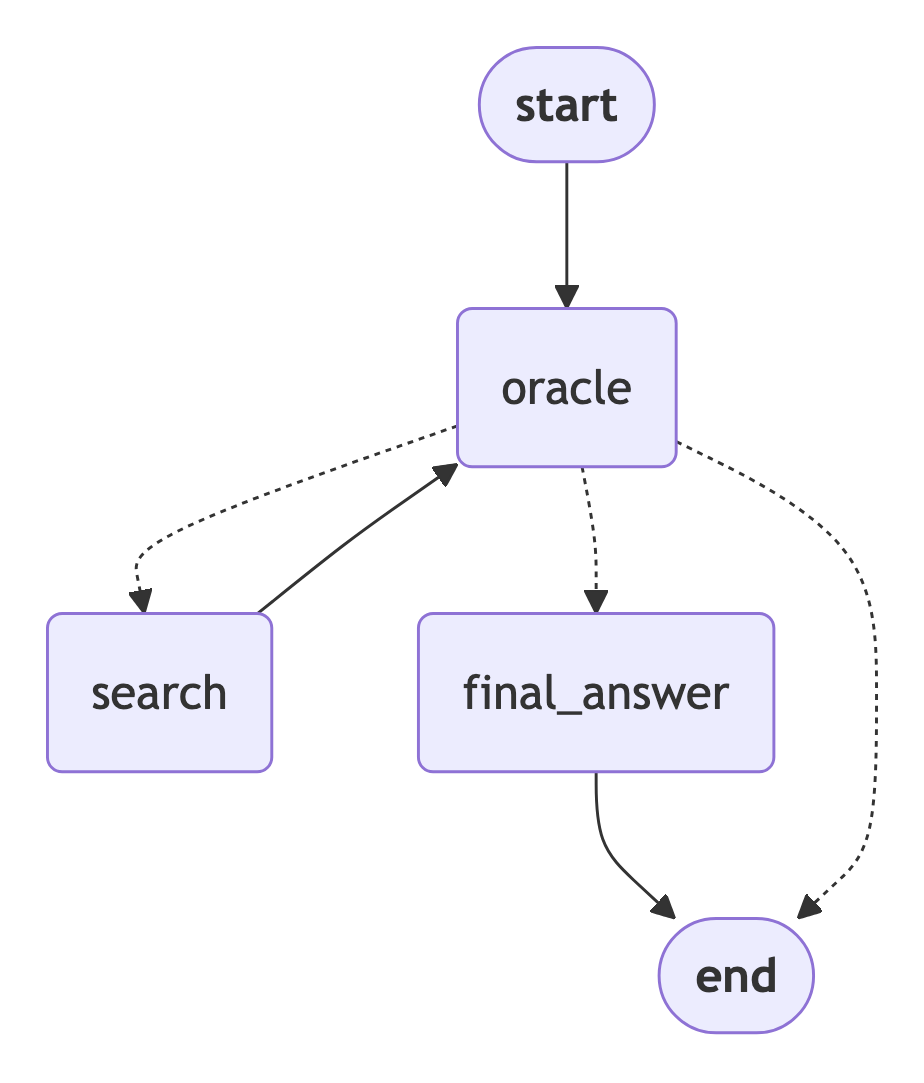

In [25]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

## Testing the Agent

Our agent has now been constructed so we can test it. First, let's check for the best pizza in Rome:

In [26]:
out = runnable.invoke({
    "input": "where is the best pizza in rome?",
    "chat_history": [],
})

run_oracle
router
run_tool | search.invoke(input={'query': 'best pizza in Rome'})
Best pizza in Rome?
Visited Rome and had one of the best pizzas of my life
Best Pizza in Rome!
run_oracle
router
run_tool | final_answer.invoke(input={'answer': 'Based on your question, I would recommend trying Seu Pizza Illuminati in Rome for an amazing pizza experience. They are known for their creative use of condiments and experiments with vegetables. If you prefer a Neapolitan-style pizza, Pizzeria da Remo or Emma might be the perfect choice for you. Both places have received great reviews from locals and visitors alike.', 'phone_number': '', 'address': ''})


We extract the answer:

In [28]:
out["output"]

{'answer': 'Based on your question, I would recommend trying Seu Pizza Illuminati in Rome for an amazing pizza experience. They are known for their creative use of condiments and experiments with vegetables. If you prefer a Neapolitan-style pizza, Pizzeria da Remo or Emma might be the perfect choice for you. Both places have received great reviews from locals and visitors alike.',
 'phone_number': '',
 'address': ''}

We are recommended [Seu Pizza Illuminati](https://maps.app.goo.gl/RMSdTUpH8D3oQETUA), a seemingly notorious pizzeria known for their less traditional and more experimental Neapolitan pizzas.

---